In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import cmasher as cmr
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
os.chdir('/n/home12/nblauch/git/RNN_multitask') # change as needed

import multitask
from multitask.wiring_cost import SpatialLoss



# Training a RNN model network on multiple cognitive tasks

Here, we implement the codes from the following paper:

> "Task representations in neural networks trained to perform many cognitive tasks." Guangyu Robert Yang, Madhura R. Joglekar, H. Francis Song, William T. Newsome & Xiao-Jing Wang (2019). [*Nature Neuroscience* Volume 22, pp. 297–306](https://www.nature.com/articles/s41593-018-0310-2).

The original Tensorflow implemetation can be found [at this repo](https://github.com/gyyang/multitask).

This code trains a RNN model for multiple types of cognitive tasks. `ei_rnn.py` is a custom RNN implementation of **continuous-time rate-neuron network dynamics**, which is commonly used in neuroscience models:

$$ \tau \dot{h} = - h + \sigma(W_{hh} h + W_{ih} s) $$

where $x$ is neural (hidden) state,  $s$ is (sensory) input, and $W_{hh}, W_{ih}$ are synaptic weight parameters (recurrent and input weights).

Note that this model uses continuous-time dynamics description, $\dot{h} = f(h(t))$, 
whereas deep-learning models use discrete-time dynamics: $h_{t+1} = f(h_{t})$.

Here's a sample code for running the RNN model:

# Spatial wiring costs

Incorporating spatial wiring costs into the network's optimization function allows us to model the fact that biology prefers solutions with less wiring cost. This is relatively simple and just requires us to embed the units in our network in a 2D space, and then choose an appropriate cost function. A good cost function should generally be high when the weight and distance is high, and low when either the weight or the distance is low. 

Here, we introduce the cost introduced by Jacobs & Jordan (1992), also used by Blauch, Behrmann, Plaut (2022):
$$ \mathcal{L}_w = \sum_{i,j}\frac{\mathcal{D}^2_{\tiny i,j}\ W^2_{\tiny i,j}}{1 + W^2_{\tiny i,j}} $$

We allow the weight and distance norms ($p_w$, $p_d$) to be freely modified, giving a more general wiring cost:
$$ \mathcal{L}_w = \sum_{i,j}\frac{\mathcal{D}^{p_d}_{\tiny i,j}\ W^{p_w}_{\tiny i,j}}{1 + W^{p_w}_{\tiny i,j}} $$

The code also supports several other cost terms. For notational simplicity we assume that the weight and distance norms are both $p$. However, $||\mathcal{D} \odot W ||^{p}_{p}$ can be written more generally as $\sum_{i,j}\mathcal{D_{i,j}}^{p_d} \ W_{i,j}^{p_w}$
- "jju": a unit-normalized version of the standard 'jj' loss. the idea here is to make it difficult to reduce the cost just by making all weights uniformly small, and to better distribute the weights across units. let $\boldsymbol{w}_i$ be the $i$-th row of $W$, corresponding to the weights onto a given hidden unit. Then let $\tilde{\boldsymbol{w}_i}=\frac{\boldsymbol{w_i}}{||\boldsymbol{w_i}||_2}$. Let $\tilde{W}=\{\tilde{\boldsymbol{w_0}}, ..., \tilde{\boldsymbol{w_h}} \}$, where $h$ is the number of hidden units. Then we simply compute the loss as in the JJ case:
$$ \mathcal{L}_w = \sum_{i,j}\frac{\mathcal{D}^2_{\tiny i,j}\ \tilde{W}^2_{\tiny i,j}}{1 + \tilde{W}^2_{\tiny i,j}} $$
- "norm"": 
$$ \mathcal{L}_w = \frac{||\mathcal{D} \odot W ||^{p}_{p}}{||W||^{p}_{p}} $$
- "dot":
$$ \mathcal{L}_w = ||\mathcal{D} \odot W ||^p_p $$
- "seRNN", (Achterberg, Akcarca et. al, 2023) where $C$ is communicability, $S$ is a diagonal matrix corresponding to the degree of each unit, and in the original work, $p=1$:
$$ \mathcal{L}_w = ||\mathcal{D} \odot W \odot C ||^p_p $$
$$ C = e^{S^{-\frac{1}{2}}|W|S^{-\frac{1}{2}}} $$

Below, we'll visualize the Jacobs & Jordan cost for a single connection across a variety of weights and distances. Most of the other costs cannot be computed for a single connection without knowledge of the full distribution of weights and distances. 

In [2]:
wiring_cost = SpatialLoss(weight_norm=2, dist_norm=2, style='jj')

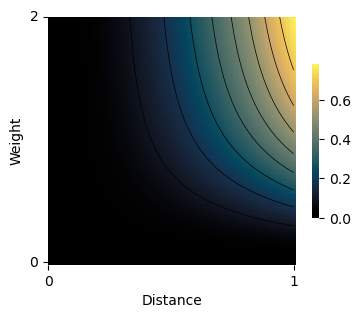

In [3]:
weights = torch.arange(2,0,-0.02)
dists = torch.arange(0,1,0.01)
costs = torch.zeros((len(weights), len(dists)))
for i, weight in enumerate(weights):
    for j, dist in enumerate(dists):
        costs[i, j] = wiring_cost.forward_oneweight(weight, dist, None)

plt.figure(figsize=(4,4), dpi=100)
sns.heatmap(costs, cmap='cmr.eclipse', square=True, cbar_kws={'shrink': 0.5})
# Add contours to the heatmap
contour_levels = np.linspace(costs.min(), costs.max(), 10)
plt.contour(costs.numpy(), levels=contour_levels, colors='black', linewidths=0.5)

plt.xlabel('Distance')
plt.ylabel('Weight')
plt.xticks([0, len(dists)-1], [0, 1], rotation=0)
plt.yticks([0, len(weights)-1], [2, 0])
plt.show()


The main training code is defined in `multitask/train.py`. Let's set up the hyperparameters before training the model

In [4]:
hp, log, optimizer = multitask.set_hyperparameters(model_dir='debug', 
                                                   hp={
                                                       'l1_h': 0,
                                                       'l2_h': 0,
                                                       'learning_rate': 0.001, 
                                                       'spatial_weight': 0.001, # lambda for the spatial loss
                                                       'spatial_style': 'sernn', # spatial loss style, e.g. 'jj', 'jju', 'norm', 'dot', 'seRNN', etc.
                                                       'spatial_weight_norm': 2, # weight norm in spatial loss
                                                       'spatial_dist_norm': 2, # distance norm in spatial loss
                                                       'n_rnn': 400, # number of hidden units per layer
                                                       'device': 'cuda', # device to run on
                                                       'batch_size_train': 512, # batch size for training
                                                       'rnn_type': 'EIEFFRNN', # one of RNN, EIEFFRNN, EIRNN, EFFRNN
                                                       'activation': 'relu', # activation function
                                                       'use_norm': False, # whether to use layer normalization; doesn't seem to work well in this paradigm
                                                       'num_layers': 2, # number of RNN layers
                                                       }, 
                                                       display_step=50,
                                                   ruleset='all', # mante, all, or oicdmc
                                                   ) #, rich_output=True)
print(hp)

{'batch_size_train': 512, 'batch_size_test': 512, 'in_type': 'normal', 'rnn_type': 'EIEFFRNN', 'use_separate_input': False, 'loss_type': 'lsq', 'optimizer': 'adam', 'activation': 'relu', 'tau': 100, 'dt': 20, 'alpha': 0.2, 'sigma_rec': 0.05, 'sigma_x': 0.01, 'w_rec_init': 'randortho', 'l1_h': 0, 'l2_h': 0, 'l1_weight': 0, 'l2_weight': 0, 'l2_weight_init': 0, 'spatial_weight': 0.001, 'spatial_style': 'sernn', 'spatial_weight_norm': 2, 'spatial_dist_norm': 2, 'clip_grad_norm': 0, 'p_weight_train': None, 'target_perf': 1.0, 'n_eachring': 32, 'num_ring': 2, 'n_rule': 2, 'rule_start': 65, 'n_input': 67, 'n_output': 33, 'n_rnn': 1024, 'ruleset': 'mante', 'save_name': 'test', 'learning_rate': 0.001, 'c_intsyn': 0, 'ksi_intsyn': 0, 'device': 'cuda', 'checkpoint_step': 500, 'use_norm': False, 'num_layers': 2, 'seed': 0, 'rng': RandomState(MT19937) at 0x7F7960302A40, 'model_dir': 'debug', 'max_steps': 10000000.0, 'display_step': 50, 'rich_output': False, 'decay': 0.8187307530779818, 'rule_trains

we can now load and train the model according to the specified hyperparameters

the model may take a while to start showing good performance -- however, usually it will eventually do so (new constraints not exhaustively tested)

one thing we can observe is that the spatial cost will usually rapidly reduce before the performance eventually starts increasing

In [ ]:
model = multitask.TopoModel(hp)
run_model = multitask.ModelWrapper(hp, model)
multitask.train(run_model, optimizer, hp, log)


to save time here, we (well, maybe just I) can also load a model by getting the hyperparameters and state dict

In [40]:
import os
import json
import torch

def load_model_from_base_fn(base_fn, model_dir='data/models'):
    # load hyperparameters
    with open(os.path.join(model_dir, base_fn, 'hparams.json'), 'r') as f:
        hp = json.load(f)
    # reinstantiate the rng
    hp['rng'] = np.random.RandomState(hp['seed'])
    # load model
    model = multitask.TopoModel(hp)
    model.load_state_dict(torch.load(os.path.join(model_dir, base_fn, 'model.pth')))
    return model, hp

model, hp = load_model_from_base_fn('LMzNJwzupE')
run_model = multitask.ModelWrapper(hp, model)

/tmp/ipykernel_1720864/3334177714.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_dir, base_fn, 'model.pth')))


Finally, let's visualize the results. The analysis functions are in `multitask/standard_analysis.py`

first, we do a standard activity plot

(100, 500, 85)
(101, 500, 800)
(100, 500, 33)


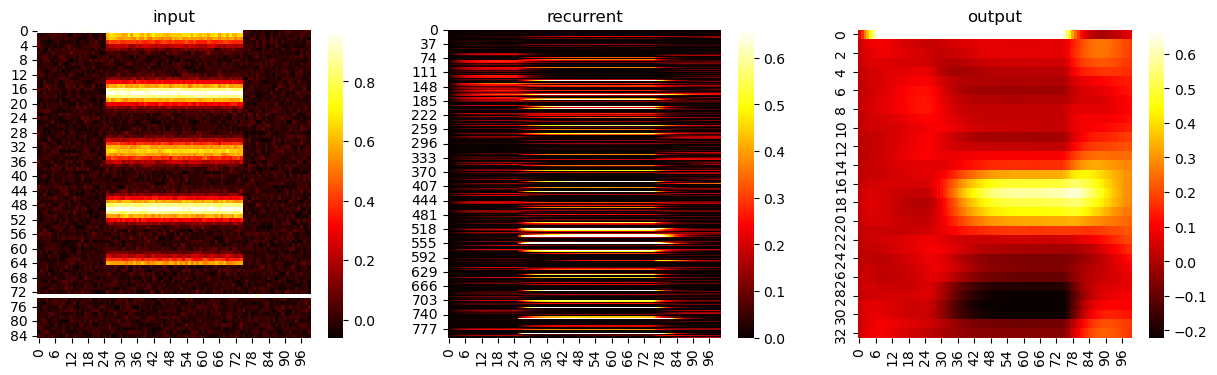

In [41]:
rule = 'contextdm1'
multitask.standard_analysis.easy_activity_plot(run_model, rule, layer=0)

next, let's visualize the weights in the RNN layers. since they are topographically, we can reshape them to reveal the spatial structure.

In [42]:
from ipywidgets import interact
import matplotlib.pyplot as plt
# multitask.standard_analysis.topo_activity_plot(run_model, rule, i_trial=1, layer=0)
# multitask.standard_analysis.topo_connectivity_plot(run_model, 300)
def fn(unit, layer, kind='hh'):
    assert not (layer == 0 and kind == 'ih')
    multitask.standard_analysis.topo_connectivity_plot(run_model, unit, layer=layer, kind=kind)
    plt.close()

interact(fn, unit=(0, run_model.model.rnn.rnncells[-1].hid_size-1), layer=(0, len(run_model.model.rnn.rnncells)-1), kind=['hh', 'ih'])

interactive(children=(IntSlider(value=199, description='unit', max=399), IntSlider(value=0, description='layer…

<function __main__.fn(unit, layer, kind='hh')>

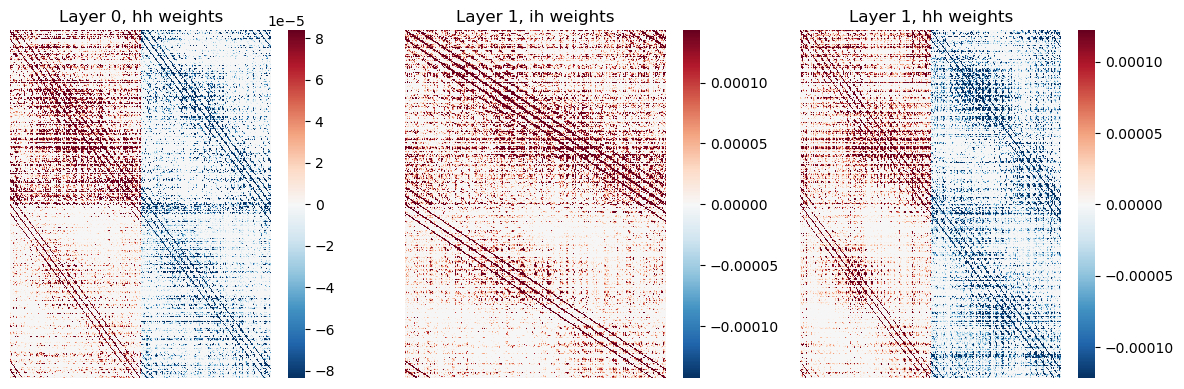

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ii, (layer, kind) in enumerate([[0, 'hh'], [1, 'ih'], [1, 'hh']]):
    weights = {}
    weights['ih'], weights['hh'] =run_model.model.rnn.rnncells[layer].get_connectivity()
    weights[kind] = weights[kind].cpu().detach().numpy()
    vmax = np.percentile(np.abs(weights[kind]), 90)
    vmin = -vmax 
    sns.heatmap(weights[kind], cmap='RdBu_r', center=0, ax=axes[ii], vmin=vmin, vmax=vmax)
    axes[ii].set_title(f'Layer {layer}, {kind} weights')
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])

plt.tight_layout()
plt.show()

## We leave it as an exercise to study the topographic organization of task responses in the network!